# Multiple Linear Regression Model for Bike Rental
## The goal
- Find the variables that are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands
## High-level Strategy
- Load the data and conduct a preliminary check
- Explore the data to find interesting patterns and anamolies
- Prepare the data for modelling. This involves converting to binary columns, replacing with dummies, dropping irrelevant columns and rescaling
- Train the model iteratively with feedback from p-values and VIF each time till a satisfactory model is reached.
- Conduct a Resudual Analysis to check the error distribution and ascertain that the assumptions for Linear Regression is respected
- Use the model built before to make the predictions on the test dataset.
- Compare the $Adjusted R^2$ of the test and predicted datasets to conclude the model.

## Utilities

In [163]:
# Imports
# from datetime import datetime
import pprint

# Data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model building
import statsmodels
import statsmodels.api as sm

# VIF calculation
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
# Data splitter
from sklearn.model_selection import train_test_split
# Scaler
from sklearn.preprocessing import MinMaxScaler
# MSE calculator
from sklearn.metrics import mean_squared_error
# R2S calculator
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

# Auto Feature Selector
from sklearn.feature_selection import RFE

# Markdown printing
from IPython.display import Markdown, display

In [164]:
# %pycodestyle_on

### Functions

In [165]:
def get_dummies(col: pd.Series, col_names: dict = None):
    """
    Gets dummies for the given series and assigns the column name as supplies. Also removes the first column.
    :param col: Series to operate on
    :param col_names: Column names to assign
    :return: 
    """
    tmp_dummy = pd.get_dummies(col, dtype=int, drop_first=True)
    if col_names is not None:
        tmp_dummy = tmp_dummy.rename(col_names, axis=1)
    return tmp_dummy

Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. 

The formula for calculating VIF is:


### $ VIF_i = \frac{1}{1 - {R_i}^2} $

In [166]:
def find_VIF(X: pd.DataFrame):
    """
    Calculates the VIF for the given data frame
    :param X: 
    :return: 
    """
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by='VIF', ascending=False)
    return vif

In [167]:
def md(string):
    """
    Prints the string argument with markdown effect

            Parameters:
                    string (str): A string to be printed

            Returns:
                    None
    """
    display(Markdown(string))

---

## Step 0: Loading and Understanding the Data

In [168]:
br = pd.read_csv("day.csv")

#### Textual Analysis

In [169]:
print("shape", br.shape)
print("dtypes\n", br.dtypes)

shape (730, 16)
dtypes
 instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


**Finding** 
- Most of them are numerical types(int64 and float64)
- `dteday` is of type 'object' and not 'datetime'
- The dtypes of these columns can be reduced to int8 or float16 accordingly to improve memory footprint(computational effeciency stays the same). But considering the number of columns(16) and records(730) the memory usage as such will not be much.

In [170]:
br.dteday = pd.to_datetime(br.dteday, format='mixed', yearfirst=True, dayfirst=True)
# br.dteday, br.dteday.dt.day, br.dteday.dt.month

In [171]:
br.head()

instant     dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1 2018-01-01       1   0     1        0        6           0   
1        2 2018-01-02       1   0     1        0        0           0   
2        3 2018-01-03       1   0     1        0        1           1   
3        4 2018-01-04       1   0     1        0        2           1   
4        5 2018-01-05       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [172]:
cols_with_na = dict()
for c in br.columns:
    if sum(br[c].isna()) > 0:
        cols_with_na[c] = sum(br[c].isna())
print("Cols with NA:", cols_with_na, end="\n")

Cols with NA: {}


**Findings**
- None of the columns have null values

In [173]:
br.describe()

instant               dteday      season          yr        mnth  \
count  730.000000                  730  730.000000  730.000000  730.000000   
mean   365.500000  2018-12-31 12:00:00    2.498630    0.500000    6.526027   
min      1.000000  2018-01-01 00:00:00    1.000000    0.000000    1.000000   
25%    183.250000  2018-07-02 06:00:00    2.000000    0.000000    4.000000   
50%    365.500000  2018-12-31 12:00:00    3.000000    0.500000    7.000000   
75%    547.750000  2019-07-01 18:00:00    3.000000    1.000000   10.000000   
max    730.000000  2019-12-31 00:00:00    4.000000    1.000000   12.000000   
std    210.877136                  NaN    1.110184    0.500343    3.450215   

          holiday     weekday  workingday  weathersit        temp       atemp  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean     0.028767    2.997260    0.683562    1.394521   20.319259   23.726322   
min      0.000000    0.000000    0.000000    1.000000    2.424346    3.953480   
25%      0.000000    1.000000    0.000000    1.000000   13.811885   16.889713   
50%      0.000000    3.000000    1.000000    1.000000   20.465826   24.368225   
75%      0.000000    5.000000    1.000000    2.000000   26.880615   30.445775   
max      1.000000    6.000000    1.000000    3.000000   35.328347   42.044800   
std      0.167266    2.006161    0.465405    0.544807    7.506729    8.150308   

              hum   windspeed       casual   registered          cnt  
count  730.000000  730.000000   730.000000   730.000000   730.000000  
mean    62.765175   12.763620   849.249315  3658.757534  4508.006849  
min      0.000000    1.500244     2.000000    20.000000    22.000000  
25%     52.000000    9.041650   316.250000  2502.250000  3169.750000  
50%     62.625000   12.125325   717.000000  3664.500000  4548.500000  
75%     72.989575   15.625589  1096.500000  4783.250000  5966.000000  
max     97.250000   34.000021  3410.000000  6946.000000  8714.000000  
std     14.237589    5.195841   686.479875  1559.758728  1936.011647

**Findings**
- Total number of records is 730
- There are 15 numerical columns (technically, it's much lesser as many of them are representations of categorical values)
- Min `cnt` is at 22 where as the median and max are at 4508 and 8714 respectively

In [174]:
br.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     730 non-null    int64         
 1   dteday      730 non-null    datetime64[ns]
 2   season      730 non-null    int64         
 3   yr          730 non-null    int64         
 4   mnth        730 non-null    int64         
 5   holiday     730 non-null    int64         
 6   weekday     730 non-null    int64         
 7   workingday  730 non-null    int64         
 8   weathersit  730 non-null    int64         
 9   temp        730 non-null    float64       
 10  atemp       730 non-null    float64       
 11  hum         730 non-null    float64       
 12  windspeed   730 non-null    float64       
 13  casual      730 non-null    int64         
 14  registered  730 non-null    int64         
 15  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), floa

**Finding** 
- No missing values

In [175]:
# br.season = br.season.astype('category')
# br.yr = br.yr.astype('category')
# br.mnth = br.mnth.astype('category')
# br.holiday = br.holiday.astype('category')
# br.weekday = br.weekday.astype('category')
# br.workingday = br.workingday.astype('category')
# br.weathersit = br.weathersit.astype('category')

# br.dtypes

---

## Step 1: Exploring the Data
- Visualise the numerical data and record the findings
- Visualise the categorical data and record the findings
- Plot a heat map and check for correlation and multiple correlation

#### Visualising Numerical Data

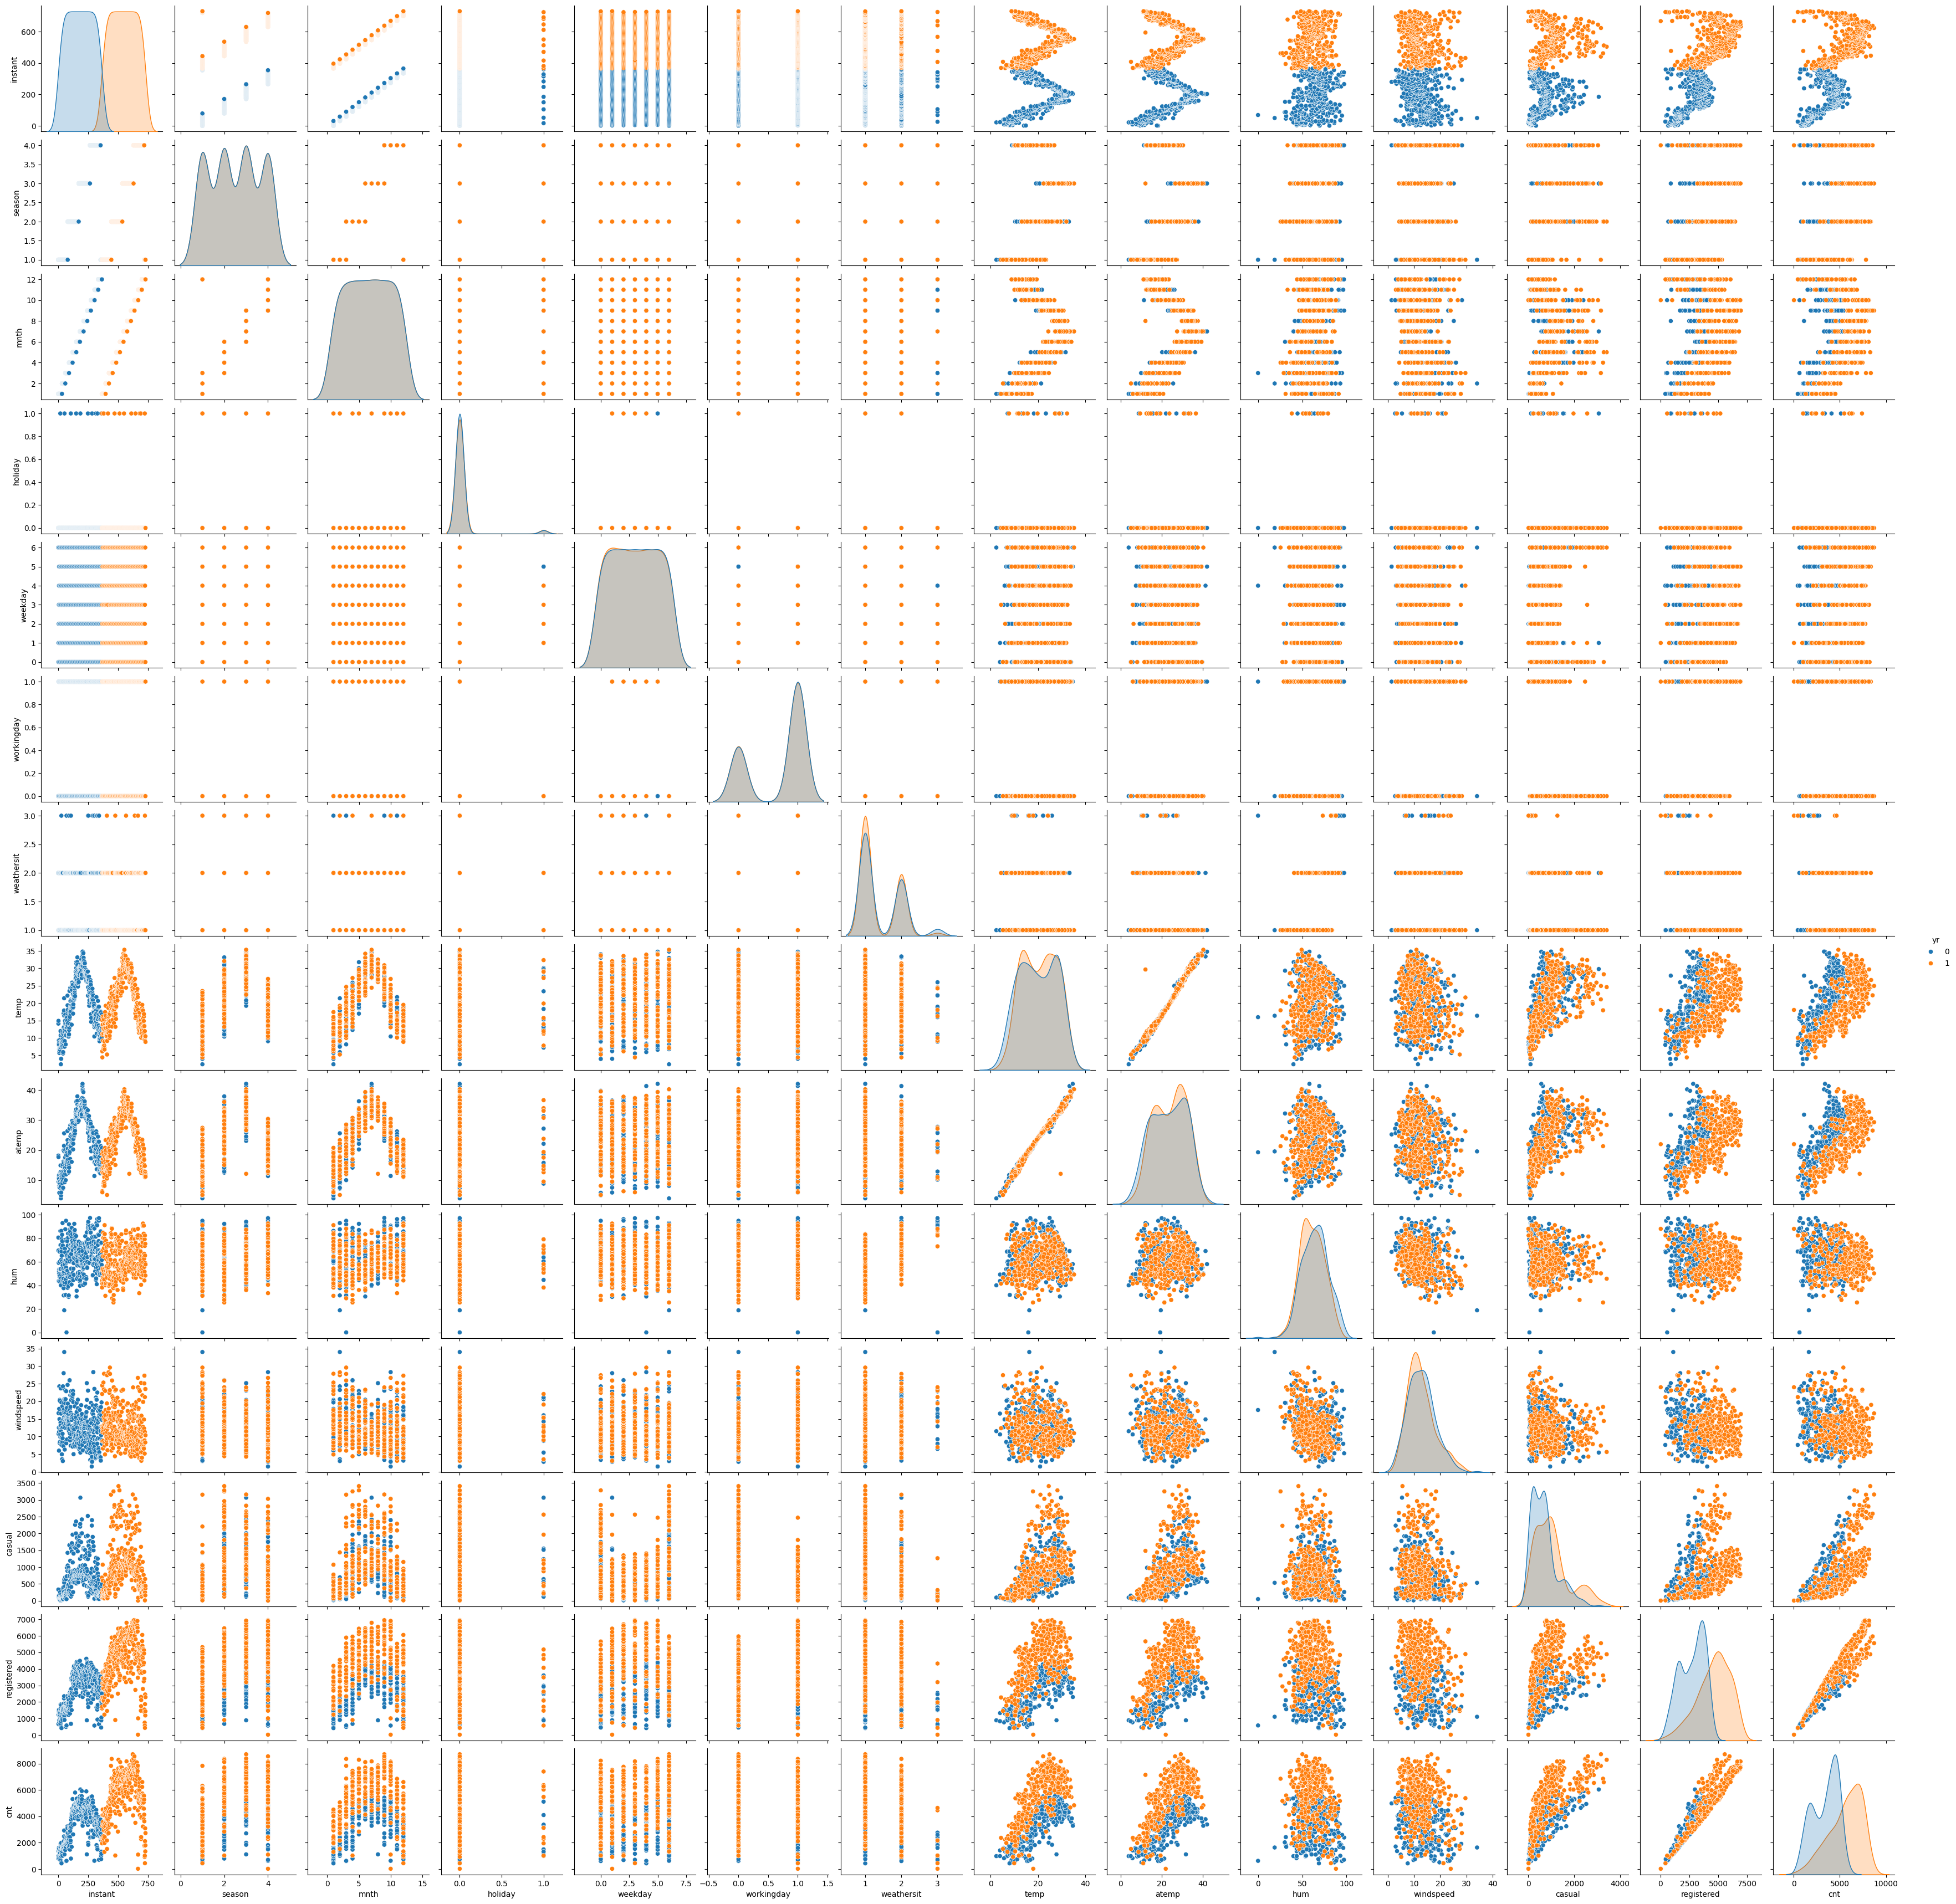

In [176]:
sns.pairplot(br, hue='yr')
plt.show()

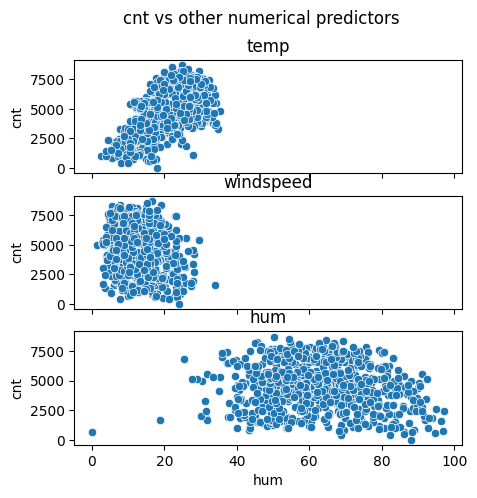

In [177]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(5, 5))
fig.suptitle('cnt vs other numerical predictors')
axes[0].set_title('temp')
axes[1].set_title('windspeed')
axes[2].set_title('hum')
sns.scatterplot(ax=axes[0], x=br.temp, y=br.cnt)
sns.scatterplot(ax=axes[1], x=br.windspeed, y=br.cnt)
sns.scatterplot(ax=axes[2], x=br.hum, y=br.cnt)
plt.show()

**Findings**<a id='vnd-findings'></a>
- Distribution for `cnt` looks OK with short tails
- The relationship between `temp` and `cnt` seems to positively correlate. So, a part of the variance in `cnt` is explained by `temp`
- More rentals happening on holidays
- More rentals on fall and summer with slightly lesser rentals on winter and spring
- More rentals were taken in the year 2019 compared to 2018
- More rentals were taken from month April to Oct with peaks in Sep and Oct
- More `casual` rentals happen on the weekends

#### Visualising Categorical Data

In [178]:
pd.options.mode.copy_on_write = True
cat_cols = br[['season', 'yr', 'holiday', 'weekday', 'workingday', 'weathersit', 'mnth']]

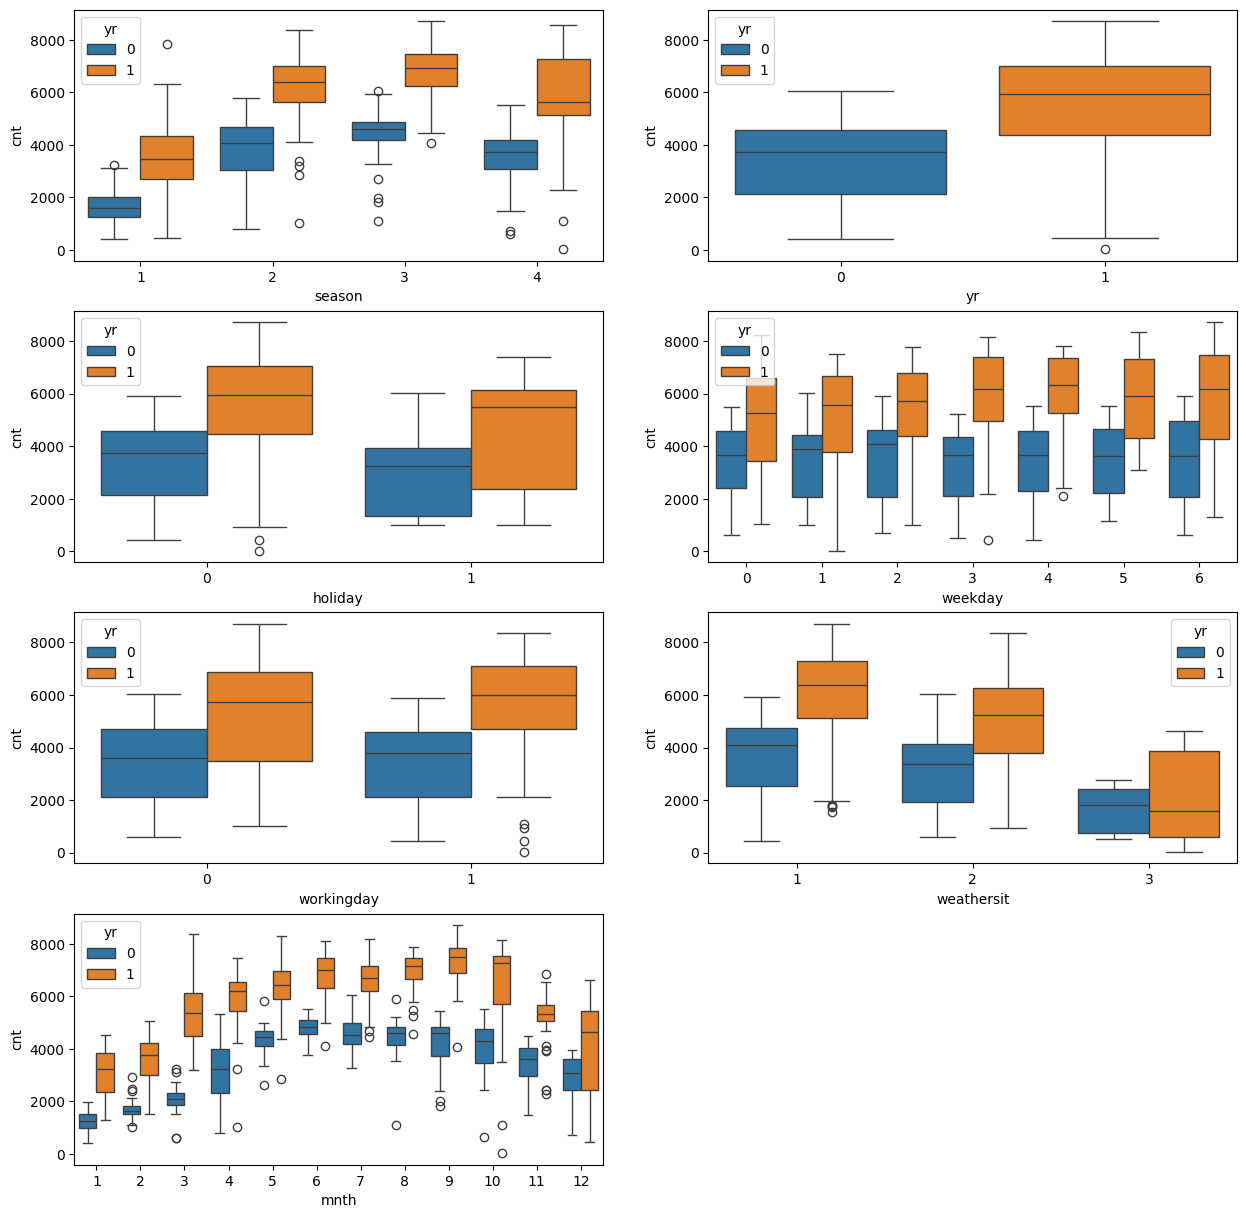

In [179]:
plt.figure(figsize=(15, 15))
for e, c in enumerate(cat_cols.columns):
    pass
    # print(c)
    plt.subplot(4, 2, e + 1)
    sns.boxplot(x=c, y='cnt', data=br, hue='yr')
plt.show()

**Findings**
- More rentals on fall and summer with slightly lesser rentals on winter and spring
- More rentals were taken in the year 2019 compared to 2018
- More rentals happening on holidays
- More rentals happening on Clear day, followed by Cloudy and Light Snow days and none on days of Heavy Rain
- More rentals were taken from month April to Oct with peaks in Sep and Oct
- All these findings agree with the the one from the [pair-plot](#vnd-findings) 


#### Correlation

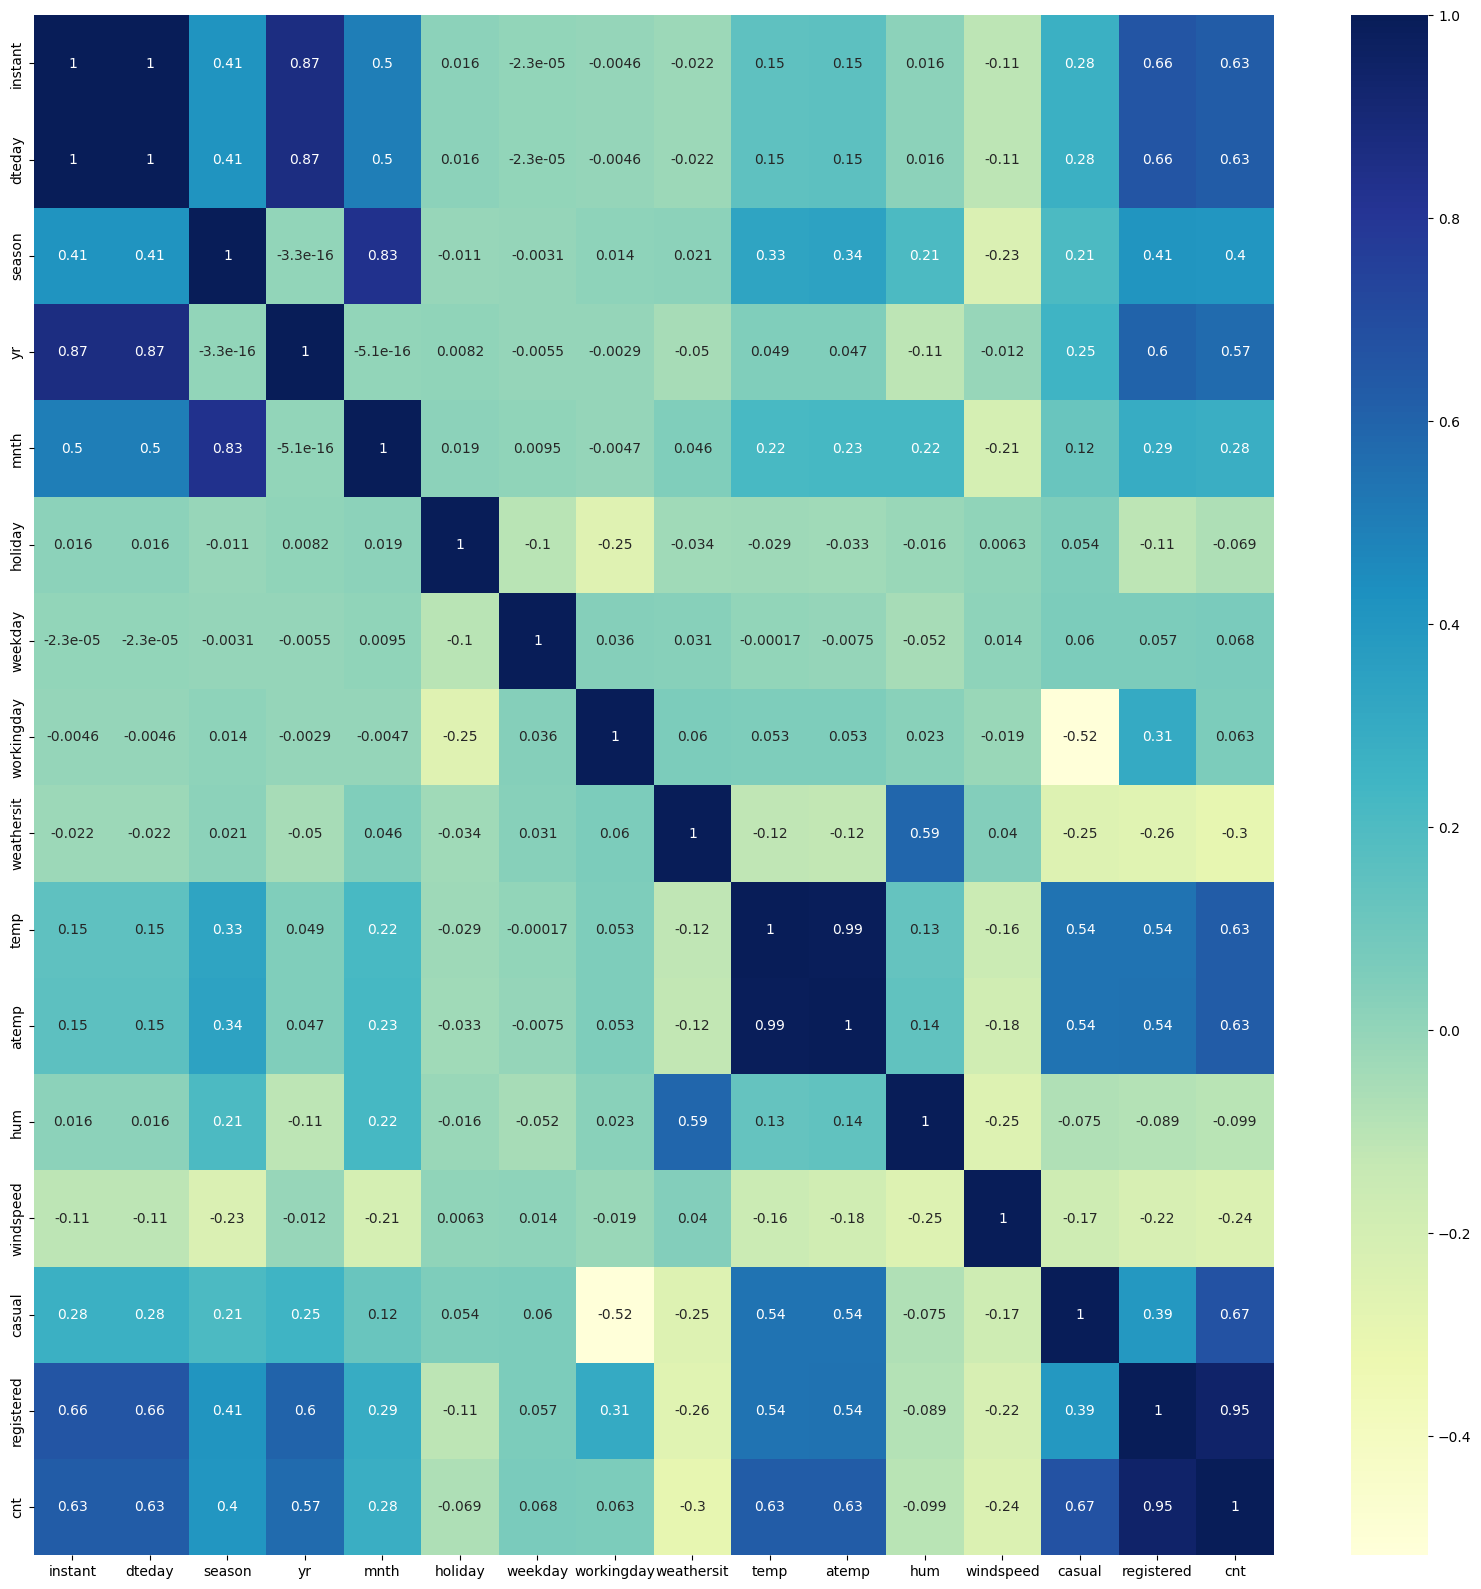

In [180]:
plt.figure(figsize=(20, 20))
sns.heatmap(br.corr(), annot=True, cmap='YlGnBu')
plt.show()

**Findings**
- There is a positive correlation between the y-variable `cnt` and `temp`, `atemp`, `season`, `dteday`, `yr` and `mnth`
- `cnt` negatively correlated to `windspeed` and `hum`
- Variables apart from correlating with `cnt`, they also correlate with themselves, like
     - `yr`, `mnth`, `season` and `dteday`
     - `temp`, `atemp`, `hum`
     - `hum` and `weathersit`
     - `season` and `temp`
- These variables that take part in multiple correlation needs close attention

---

## Step 2: Data Preparation for Modelling
- Get dummies for the categorical columns
- Drop columns that are multi-correlating with other columns and that are redundant
- Rescale the variables that are out of scale
- Split the data into training and testing sets

### Variable types

#### Categorical
1. `instant`
2. `dteday`
3. `season`
4. `yr`
5. `mnth`
6. `holiday`
7. `weekday`
8. `workingday`
9. `weathersit`

#### Numreical
1. `temp`
11. `atemp`
12. `hum`
13. `windspeed`
14. `casual`
15. `registered`
16. `cnt`

**Note**: Target `cnt` is a continous variable; hence Linear regression is feasible

### Plan for data
1. `instant` - is not relevant, can be removed last after treating other columns
2. `dteday` - convert to datetime dtype, can be removed after Exploratory Analysis
3. `season` - get dummies then remove
4. `yr` - retain
5. `mnth` - get dummies then remove
6. `holiday` - retain and get dummies
7. `weekday` - get dummies then remove
8. `workingday` - remove and use `holiday`
9. `weathersit` - get dummies then remove
10. `temp` - rescale
11. `atemp` - remove
12. `hum` - rescale
13. `windspeed` - rescale
14. `casual` -  scale (later)
15. `registered` -  scale (later)
16. `cnt` -  rescale (later) **To be Predicted**

### Get dummies

In [181]:
md(f"Columns before concatenation: **{len(br.columns)}**")
weekday_dummy = get_dummies(br.weekday, {1: 'weekday_1', 2: 'weekday_2', 3: 'weekday_3', 4: 'weekday_4', 5: 'weekday_5',
                                         6: 'weekday_6'})
weathersit_dummy = get_dummies(br.weathersit, {2: 'weather_mist', 3: 'weather_light_rain'})
mnth_dummy = get_dummies(br.mnth,
                         {1: 'mnth_Jan', 2: 'mnth_Feb', 3: 'mnth_Mar', 4: 'mnth_Apr', 5: 'mnth_May', 6: 'mnth_Jun',
                          7: 'mnth_Jul', 8: 'mnth_Aug', 9: 'mnth_Sep', 10: 'mnth_Oct', 11: 'mnth_Nov', 12: 'mnth_Dec'})
season_dummy = get_dummies(br.season, {2: 'season_summer', 3: 'season_fall', 4: 'season_winter'});

# Concatenate the dummy dataframes into the operating dataframe br
br = pd.concat([br, weekday_dummy, weathersit_dummy, mnth_dummy, season_dummy], axis=1)
md(f"Columns after concatenation: **{len(br.columns)}**")

Columns before concatenation: **16**

Columns after concatenation: **38**

### Drop columns

In [182]:
md(f"Columns before dropping: **{len(br.columns)}**")

# Drop all those columns that are made redundant by the dummies
br = br.drop(['weekday', 'weathersit', 'mnth', 'season'], axis = 1)

# Drop all those columns that are redundant
br = br.drop(['instant','dteday','casual','registered', 'atemp', 'workingday'], axis = 1)

md(f"Columns after dropping: **{len(br.columns)}**")


Columns before dropping: **38**

Columns after dropping: **28**

In [183]:
# # 'instant' can be dropped
# br = br.drop('instant', axis=1)
# if 'instant' in br.columns:
#     print('Found')
# else:
#     print('Removed')
# # season : season (1:spring, 2:summer, 3:fall, 4:winter)
br.head()

yr  holiday       temp      hum  windspeed   cnt  weekday_1  weekday_2  \
0   0        0  14.110847  80.5833  10.749882   985          0          0   
1   0        0  14.902598  69.6087  16.652113   801          0          0   
2   0        0   8.050924  43.7273  16.636703  1349          1          0   
3   0        0   8.200000  59.0435  10.739832  1562          0          1   
4   0        0   9.305237  43.6957  12.522300  1600          0          0   

   weekday_3  weekday_4  ...  mnth_Jun  mnth_Jul  mnth_Aug  mnth_Sep  \
0          0          0  ...         0         0         0         0   
1          0          0  ...         0         0         0         0   
2          0          0  ...         0         0         0         0   
3          0          0  ...         0         0         0         0   
4          1          0  ...         0         0         0         0   

   mnth_Oct  mnth_Nov  mnth_Dec  season_summer  season_fall  season_winter  
0         0         0         0              0            0              0  
1         0         0         0              0            0              0  
2         0         0         0              0            0              0  
3         0         0         0              0            0              0  
4         0         0         0              0            0              0  

[5 rows x 28 columns]

In [184]:
# plt.figure(figsize=(20, 20))
# sns.heatmap(br.corr(), annot=True, cmap='YlGnBu')
# plt.show()
br.columns

Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'cnt', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'weather_mist', 'weather_light_rain', 'mnth_Feb', 'mnth_Mar',
       'mnth_Apr', 'mnth_May', 'mnth_Jun', 'mnth_Jul', 'mnth_Aug', 'mnth_Sep',
       'mnth_Oct', 'mnth_Nov', 'mnth_Dec', 'season_summer', 'season_fall',
       'season_winter'],
      dtype='object')

### Split into Training and Testing set

In [185]:
br_train, br_test = train_test_split(br, train_size=0.7, test_size=0.3, random_state=100)
md(f"Training dataset (70%): **{br_train.shape}** <br/>Test dataset(30%): **{br_test.shape}**")

Training dataset (70%): **(510, 28)** <br/>Test dataset(30%): **(219, 28)**

### Rescaling

In [186]:
rescaler = MinMaxScaler()
to_rescale = ['temp', 'hum', 'windspeed', 'cnt']
br_train[to_rescale] = rescaler.fit_transform(br_train[to_rescale])

br_train.describe()

yr     holiday        temp         hum   windspeed         cnt  \
count  510.000000  510.000000  510.000000  510.000000  510.000000  510.000000   
mean     0.507843    0.025490    0.537262    0.650369    0.320768    0.513620   
std      0.500429    0.157763    0.225844    0.145882    0.169797    0.224593   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.339853    0.538643    0.199179    0.356420   
50%      1.000000    0.000000    0.540519    0.653714    0.296763    0.518638   
75%      1.000000    0.000000    0.735215    0.754830    0.414447    0.684710   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

        weekday_1   weekday_2   weekday_3   weekday_4  ...    mnth_Jun  \
count  510.000000  510.000000  510.000000  510.000000  ...  510.000000   
mean     0.150980    0.131373    0.158824    0.133333  ...    0.074510   
std      0.358381    0.338139    0.365870    0.340268  ...    0.262857   
min      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
25%      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
50%      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
75%      0.000000    0.000000    0.000000    0.000000  ...    0.000000   
max      1.000000    1.000000    1.000000    1.000000  ...    1.000000   

         mnth_Jul    mnth_Aug    mnth_Sep    mnth_Oct    mnth_Nov    mnth_Dec  \
count  510.000000  510.000000  510.000000  510.000000  510.000000  510.000000   
mean     0.076471    0.096078    0.080392    0.086275    0.086275    0.084314   
std      0.266010    0.294988    0.272166    0.281045    0.281045    0.278131   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

       season_summer  season_fall  season_winter  
count     510.000000   510.000000      510.00000  
mean        0.245098     0.262745        0.24902  
std         0.430568     0.440557        0.43287  
min         0.000000     0.000000        0.00000  
25%         0.000000     0.000000        0.00000  
50%         0.000000     0.000000        0.00000  
75%         0.000000     1.000000        0.00000  
max         1.000000     1.000000        1.00000  

[8 rows x 28 columns]

In [187]:
for c in to_rescale:
    md(f"**{c}** min: {br_train[c].min()}, max: {br_train[c].max()}")

**temp** min: 0.0, max: 0.9999999999999998

**hum** min: 0.0, max: 0.9999999999999999

**windspeed** min: 0.0, max: 1.0

**cnt** min: 0.0, max: 1.0000000000000002

---

## Step 3: Training the Model
1. Get `X_train` and `y_train` from the `br_train` dataset
2. Using RFE, eliminate the insignificant fields
3. Build the models till the VIF gets below 5 and the predictor p-values gets below 0.05 (assumed significance for this problem)

### Get X and y from the training dataset

In [188]:
# y_train is 'cnt'
y_train = br_train.pop('cnt')
# X_train has other columns but 'cnt'
X_train = br_train
md(f"Rows in y_train: **{y_train.shape[0]}**")
md(f"Rows, Columns in X_train: **{X_train.shape}**")

Rows in y_train: **510**

Rows, Columns in X_train: **(510, 27)**

### Feature Selection
Planning to use a hybrid model, i.e, to use *RFE(Recursive Feature Elimination)* for automatic elimination and manually inspect the columns for further improvements. 

In [189]:
model = LinearRegression()
model.fit(X_train, y_train)

rfe = RFE(model, step=18)
rfe = rfe.fit(X_train, y_train)

In [190]:
z = list(zip(X_train.columns,rfe.support_,rfe.ranking_))
for d in z:
    if(d[1]):
        md(f"<font color='green'>**{d[0]}**: Ranking: {d[2]}</font>")
    else:
        md(f"<font color='red'>**{d[0]}**: Ranking: {d[2]}</font>")
    

<font color='green'>**yr**: Ranking: 1</font>

<font color='green'>**holiday**: Ranking: 1</font>

<font color='green'>**temp**: Ranking: 1</font>

<font color='green'>**hum**: Ranking: 1</font>

<font color='green'>**windspeed**: Ranking: 1</font>

<font color='red'>**weekday_1**: Ranking: 2</font>

<font color='red'>**weekday_2**: Ranking: 2</font>

<font color='red'>**weekday_3**: Ranking: 2</font>

<font color='red'>**weekday_4**: Ranking: 2</font>

<font color='red'>**weekday_5**: Ranking: 2</font>

<font color='red'>**weekday_6**: Ranking: 2</font>

<font color='red'>**weather_mist**: Ranking: 2</font>

<font color='green'>**weather_light_rain**: Ranking: 1</font>

<font color='red'>**mnth_Feb**: Ranking: 2</font>

<font color='green'>**mnth_Mar**: Ranking: 1</font>

<font color='red'>**mnth_Apr**: Ranking: 2</font>

<font color='green'>**mnth_May**: Ranking: 1</font>

<font color='red'>**mnth_Jun**: Ranking: 2</font>

<font color='red'>**mnth_Jul**: Ranking: 2</font>

<font color='green'>**mnth_Aug**: Ranking: 1</font>

<font color='green'>**mnth_Sep**: Ranking: 1</font>

<font color='green'>**mnth_Oct**: Ranking: 1</font>

<font color='red'>**mnth_Nov**: Ranking: 2</font>

<font color='red'>**mnth_Dec**: Ranking: 2</font>

<font color='green'>**season_summer**: Ranking: 1</font>

<font color='red'>**season_fall**: Ranking: 2</font>

<font color='green'>**season_winter**: Ranking: 1</font>

In [191]:
to_consider = X_train.columns[rfe.support_]
md(f"Gather all the supported columns: **{to_consider}**")

Gather all the supported columns: **Index(['yr', 'holiday', 'temp', 'hum', 'windspeed', 'weather_light_rain',
       'mnth_Mar', 'mnth_May', 'mnth_Aug', 'mnth_Sep', 'mnth_Oct',
       'season_summer', 'season_winter'],
      dtype='object')**

In [192]:
md(f"Reject all the unsupported columns: **{X_train.columns[~rfe.support_]}**")

Reject all the unsupported columns: **Index(['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weather_mist', 'mnth_Feb', 'mnth_Apr', 'mnth_Jun',
       'mnth_Jul', 'mnth_Nov', 'mnth_Dec', 'season_fall'],
      dtype='object')**

In [193]:
X_train_rfe = X_train[to_consider]

### Training the Models
#### Strategy
- Build the models progressively
- Handle cases as in the [guideline](#guideline)
- Stop when the model has
    - All the predictor coeffecients are at a p-value < 0.05
    - VIF of predictor variables are < 5.0

#### Cases to handle <a href='guideline'/>
1. High P, High VIF (low significance and high multicorrelation) - To be removed
2. High P, Low VIF (low significance and high multicorrelation) - remove them first and rebuild
3. Low P, High VIF (high significance and low multicorrelation) - remove them after step 2 is exhausted
4. Low P, Low VIF (high significance and low multicorrelation) - To be retained

### Model I

#### Analyze VIF

In [194]:
find_VIF(X_train_rfe)

Features    VIF
3                  hum  10.45
2                 temp   8.80
4            windspeed   3.74
12       season_winter   2.32
11       season_summer   2.30
0                   yr   2.02
7             mnth_May   1.63
8             mnth_Aug   1.60
10            mnth_Oct   1.60
9             mnth_Sep   1.34
6             mnth_Mar   1.25
5   weather_light_rain   1.10
1              holiday   1.04

#### Build

In [195]:
# Adds a Series of constant 1. statsmodel expects a value for the intercept
X_train_rfe = sm.add_constant(X_train_rfe)

In [196]:
model = sm.OLS(y_train, X_train_rfe)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     194.4
Date:                Mon, 23 Sep 2024   Prob (F-statistic):          4.51e-185
Time:                        20:35:20   Log-Likelihood:                 499.38
No. Observations:                 510   AIC:                            -970.8
Df Residuals:                     496   BIC:                            -911.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2819      0

#### Outcome
- p-value is low for `temp` and `hum` but their VIF values are high. Hence wait.
- p-value is high for `mnth-Mar` and `mnth-May`, but their VIF values are low. Hence drop them.

### Model II

In [197]:
# Removing high p-value weekday_3, weekday_5
X_train_rfe = X_train_rfe.drop(['mnth_May', 'mnth_Mar'], axis=1)
X_train_rfe.columns

Index(['const', 'yr', 'holiday', 'temp', 'hum', 'windspeed',
       'weather_light_rain', 'mnth_Aug', 'mnth_Sep', 'mnth_Oct',
       'season_summer', 'season_winter'],
      dtype='object')

#### Analyze VIF

In [198]:
find_VIF(X_train_rfe)

Features    VIF
0                const  41.27
11       season_winter   1.71
3                 temp   1.50
9             mnth_Oct   1.49
7             mnth_Aug   1.45
10       season_summer   1.38
4                  hum   1.26
8             mnth_Sep   1.24
5            windspeed   1.16
6   weather_light_rain   1.12
1                   yr   1.03
2              holiday   1.01

#### Build

In [199]:
X_train_rfe.columns

Index(['const', 'yr', 'holiday', 'temp', 'hum', 'windspeed',
       'weather_light_rain', 'mnth_Aug', 'mnth_Sep', 'mnth_Oct',
       'season_summer', 'season_winter'],
      dtype='object')

In [200]:
# X_train_rfe = sm.add_constant(X_train_rfe)
X_train_rfe.columns

Index(['const', 'yr', 'holiday', 'temp', 'hum', 'windspeed',
       'weather_light_rain', 'mnth_Aug', 'mnth_Sep', 'mnth_Oct',
       'season_summer', 'season_winter'],
      dtype='object')

In [201]:
model = sm.OLS(y_train, X_train_rfe)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     228.0
Date:                Mon, 23 Sep 2024   Prob (F-statistic):          2.03e-186
Time:                        20:35:20   Log-Likelihood:                 496.98
No. Observations:                 510   AIC:                            -970.0
Df Residuals:                     498   BIC:                            -919.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2836      0

#### Outcome
- p-value is high for `mnth_Oct`. Hence drop it.
- VIF values are well within the limit(5) for all the features.

### Model III

In [202]:
# Removing high p-value weekday_3, weekday_5
X_train_rfe = X_train_rfe.drop(['mnth_Oct'], axis=1)
X_train_rfe.columns

Index(['const', 'yr', 'holiday', 'temp', 'hum', 'windspeed',
       'weather_light_rain', 'mnth_Aug', 'mnth_Sep', 'season_summer',
       'season_winter'],
      dtype='object')

#### Analyze VIF

In [203]:
find_VIF(X_train_rfe)

Features    VIF
0                const  40.54
3                 temp   1.45
7             mnth_Aug   1.43
9        season_summer   1.37
10       season_winter   1.31
4                  hum   1.26
8             mnth_Sep   1.21
5            windspeed   1.16
6   weather_light_rain   1.11
1                   yr   1.02
2              holiday   1.01

#### Build

In [204]:
model = sm.OLS(y_train, X_train_rfe)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     248.7
Date:                Mon, 23 Sep 2024   Prob (F-statistic):          1.16e-186
Time:                        20:35:20   Log-Likelihood:                 494.69
No. Observations:                 510   AIC:                            -967.4
Df Residuals:                     499   BIC:                            -920.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2762      0

#### Outcome
- All the predictor coeffecients are at a p-value < 0.05
- VIF of predictor variables are < 5
- F-statistic is high, hence the predictor variables are significant
- Prob (F-statistic) is 1.16e-186 which is very close to zero. Good to reject null hypothesis.
- The model looks satisfactory at this point. Can proceed to Residual Analysis

## Step 4: Residual Analysis
1. Predict the `cnt` values for the given `X_train` data using the above finalized `lm` model. Call it `y_train_cnt`
2. Plot the distribution of the error component (`y_train - y_train_cnt`)
3. Observe and analyze the distribution to verify 

In [205]:
y_train_cnt = result.predict(X_train_rfe)
residuals = y_train - y_train_cnt

<Figure size 640x480 with 0 Axes>

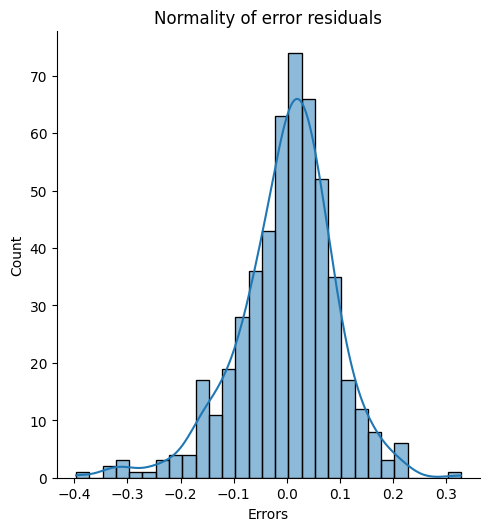

In [206]:
fig = plt.figure()
sns.displot(residuals, kind='hist', kde=True)
plt.title("Normality of error residuals")
fig.suptitle('Error Terms', fontsize = 20)
plt.xlabel('Errors', fontsize = 10)
plt.show()

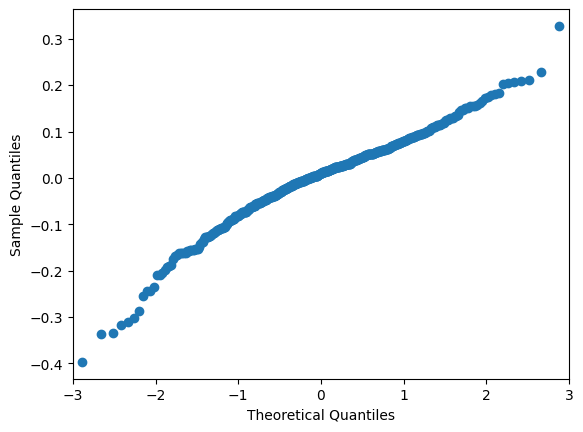

In [207]:
sm.qqplot(residuals)
plt.show()

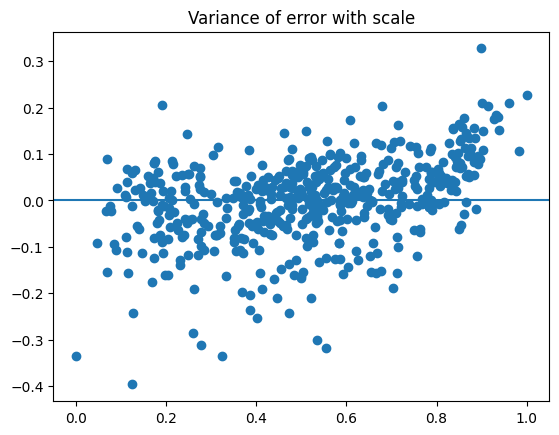

In [208]:
plt.scatter(x=y_train, y=residuals)
plt.title("Variance of error with scale")
plt.axhline(0)
plt.show()

### Observation

1. Shape of 'Normality of Residuals' plot, looks like normally distributed and is centered around 0.
2. From the Q-Q plot we can confirm that the error distribution is infact normal.
3. The distribution is uniform across the range of y; hence it is Homoscedasticity.
4. The data is [linear](#vnd-findings)
5. With `atemp` dropped from the dataset, perfect multicollinearity is also taken care.

Hence the fundamental assumptions of the Linear Regression is respected

---

## Step 5: Predict
- The objective is to predict the y-values for the given `X_test` values and see how close or far they are from `y_test` values
- Rescale the siginficant numerical columns that were found in `X_test_rfe`
- Split the test data br_test into `y_test` and `X_test` datasets and add a constant to `X_test`
- Apply the model `lm` on `X_test` and predict the dataset `y_pred`
- Check the VIF value from the summary and verify that it is closer to the VIF from the `X_train` data using the same model `lm`
- Through a scatter plot, make sure `y_test` and `y_pred` are linear in nature

### Prepare Test Data

In [209]:
X_train_rfe.columns

Index(['const', 'yr', 'holiday', 'temp', 'hum', 'windspeed',
       'weather_light_rain', 'mnth_Aug', 'mnth_Sep', 'season_summer',
       'season_winter'],
      dtype='object')

In [210]:
num_cols = ['temp', 'hum', 'windspeed', 'cnt']
br_test[num_cols] = rescaler.fit_transform(br_test[num_cols])

In [211]:
#Splitting the Test Set into X and y
y_test = br_test.pop('cnt')
X_test = br_test
md(f"Rows in y_train: **{y_test.shape[0]}**")
md(f"Rows, Columns in X_train: **{X_test.shape}**")

Rows in y_train: **219**

Rows, Columns in X_train: **(219, 27)**

In [212]:
# Need only the columns choosen by RFE and manual inspection minus the 'const'
tmp = X_train_rfe.drop(['const'], axis=1)
#Dropping the already dropped variables in the Test dataset 
X_test = X_test[tmp.columns]

# Adding a constant variable 
X_test = sm.add_constant(X_test)

In [213]:
y_test.head()

184    0.704300
535    0.725421
299    0.278853
221    0.545512
152    0.569148
Name: cnt, dtype: float64

In [214]:
X_test.head()

const  yr  holiday      temp       hum  windspeed  weather_light_rain  \
184    1.0   0        1  0.837241  0.534223   0.149393                   0   
535    1.0   1        0  0.911423  0.470417   0.231142                   0   
299    1.0   0        0  0.496221  0.777843   0.443398                   0   
221    1.0   0        0  0.890387  0.236659   0.449707                   0   
152    1.0   0        0  0.821739  0.070765   0.682387                   0   

     mnth_Aug  mnth_Sep  season_summer  season_winter  
184         0         0              0              0  
535         0         0              1              0  
299         0         0              0              1  
221         1         0              0              0  
152         0         0              1              0

### Predict

In [215]:
y_pred = result.predict(X_test)

Text(0, 0.5, 'y_pred')

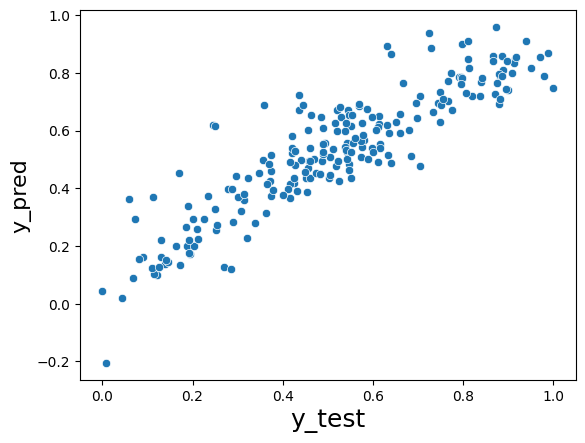

In [216]:
sns.scatterplot(x=y_test, y = y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)
plt.xlabel('y_test', fontsize=18)
plt.ylabel('y_pred', fontsize=16)

In [217]:
model_predict = sm.OLS(y_test, X_test)
result_predict = model_predict.fit()
print(result_predict.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     92.51
Date:                Mon, 23 Sep 2024   Prob (F-statistic):           6.53e-71
Time:                        20:35:20   Log-Likelihood:                 189.10
No. Observations:                 219   AIC:                            -356.2
Df Residuals:                     208   BIC:                            -318.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1634      0

### Observation
**The $Adjusted R^2$ of test and the predicted datasets are 83% and 80.8% respecrively. The difference (2.2%) is minimal and hence the estimated model is satisfactorily close to the actual.**

---

## Step 6: The final equation
```python
    cnt = 0.2762 
    + 0.2265 * yr 
    - 0.0897 * holiday 
    + 0.5666 * temp 
    - 0.2864 * hum 
    - 0.2014 * windspeed 
    - 0.1917 * weather_light_rain 
    + 0.0494 * mnth_Aug 
    + 0.1187 * mnth_Sep 
    + 0.1002 * season_summer 
    + 0.1521 * season_winter

---

## Clean-up

In [218]:
#%pycodestyle_off